In [33]:
import copy

from itertools import product
import numpy as np

import pint.toa as toa
import pint.models as models
import pint.residuals as r
import pint.fitter as fit

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import Angle

from tqdm.notebook import tqdm

In [2]:
t = toa.get_TOAs("./datafiles/PvT/B1112+50_test_t2.tim", usepickle=False)

INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Observatory prao, loading clock file /home/andr/work/PINT/src/pint/datafiles/time.dat [pint.observatory.topo_obs]
INFO: Loading tempo observatory (None) clock correction file /home/andr/work/PINT/src/pint/datafiles/time.dat [pint.observatory.clock_file]
INFO: Evaluating observatory clock corrections. [pint.observatory.topo_obs]
INFO: Applying GPS to UTC clock correction (~few nanoseconds) [pint.observatory.topo_obs]
INFO: Observatory prao, loading GPS clock file /home/andr/work/PINT/src/pint/datafiles/gps2utc.clk [pint.observatory.topo_obs]
INFO: Loading tempo2 observatory clock correction file /home/andr/work/PINT/src/pint/datafiles/gps2utc.clk [pint.observatory.clock_file]
INFO: Applying TT(TAI) to TT(BIPM) clock correction (~27 us) [pint.observatory.topo_obs]
INFO: Observatory prao, loading BIPM clock file /home/andr/work/PINT/src/pint/dataf

INFO: Computing TDB columns. [pint.toa]
INFO: Doing astropy mode TDB conversion [pint.observatory]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]


In [3]:
start_param = models.get_model("./datafiles/1112_start.par")

In [4]:
# подготовка параметров к подону
start_param.F1.value = 0.0
start_param.F1.frozen = False
start_param.F0.frozen = False
start_param.RAJ.frozen = False
start_param.DECJ.frozen = False

In [5]:
print(start_param.as_parfile())

PSR                              J1112+50
RAJ                     11:15:38.40000000 1
DECJ                    50:30:12.29000000 1
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                                  0.603 1
F1                                    0.0 1
PEPOCH             49334.0000000000000000
PLANET_SHAPIRO                          N
DM                                    9.0
DM1                                   0.0



In [68]:
ra_pulsar_from_file = start_param.RAJ.quantity
dec_pulsar_from_file = start_param.DECJ.quantity
ra_range = Angle('0h02m00.0s')
dec_range = Angle('0d30m00.0s')

In [69]:
ra_start = ra_pulsar_from_file - ra_range
ra_stop = ra_pulsar_from_file + ra_range
dec_start = dec_pulsar_from_file - dec_range
dec_stop = dec_pulsar_from_file + dec_range

In [70]:
step_ra = Angle('0h00m05.0s')
step_dec = Angle('0d00m24.0s')
print(step_ra, step_dec)

0h00m05s 0d00m24s


In [71]:
numbers_ra = int(round(((ra_stop-ra_start)/step_ra).value))
numbers_dec = int(round(((dec_stop-dec_start)/step_dec).value))

In [74]:
ra_brutforce = np.linspace(ra_start, ra_stop, numbers_ra)
dec_brutforce = np.linspace(dec_start, dec_stop, numbers_dec)
freq_brutforce = [f'{start_param.F0.value}{i}' for i in range(qua_freq)]

In [156]:
elem_list = list(product(freq_brutforce, ra_brutforce, dec_brutforce))
final_result = []

In [157]:
for p, ra, dec in tqdm(elem_list):

    current_param = copy.copy(start_param)
    current_param.F0.value = p
    current_param.RAJ.quantity = ra
    current_param.DECJ.quantity = dec

    f = fit.WLSFitter(t, current_param)
    f.fit_toas()
    final_result.append(np.std(f.resids.time_resids))

In [ ]:
Незабыть сохранять параметры

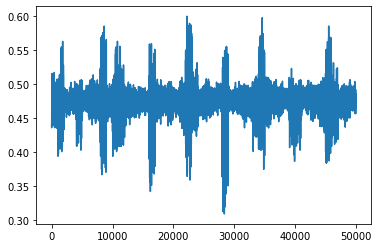

In [158]:
plt.clf()
plt.plot(final_result)

In [136]:
print(current_param.as_parfile())

PSR                              J1112+50
RAJ                     11:13:38.40000000 1
DECJ                    50:05:03.19909091 1
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                                  0.603 1
F1                                    0.0 1
PEPOCH             49334.0000000000000000
PLANET_SHAPIRO                          N
DM                                    9.0
DM1                                   0.0



In [132]:
dec

<Angle 50.07412096 deg>

In [137]:
f = fit.WLSFitter(t, current_param)
f.fit_toas()

<Quantity 7.91044924e+09>

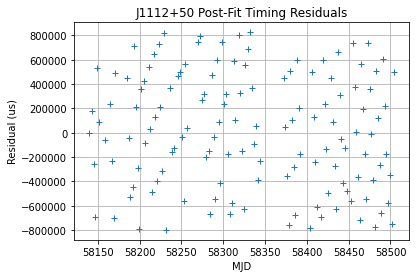

In [138]:
plt.plot(t.get_mjds(), f.resids.time_resids.to(u.us), '+')
plt.title("%s Post-Fit Timing Residuals" % start_param.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

In [139]:
np.std(f.resids.time_resids)

<Quantity 0.46599818 s>